Caricamento dataset

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("/content/dataset_LUMINAL_A_B(in).csv")
# Separare features (gene expression) e labels (Luminal A/B)
X = dataset.drop('l', axis=1).values  # Le espressioni geniche
y = dataset['l'].values  # Le etichette (Luminal A/B)

dataset.sample()
X[0]
y[0]
#in X ci sono i nodi(righe) con le features/gene expressions(colonne)
#in y ci sono le ground truths/labels per ogni nodo(riga)

'Luminal A    '

Preprocessing dati e labels

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


encoder = LabelEncoder()
y = encoder.fit_transform(y)
#Le etichette vengono convertite in formato numerico (0,1) per poter essere utilizzate in modelli di machine learning.

GNN: Creo il grafo, con gli edges, labels, features, costruisco GNN e la addestro e testo


In [114]:
import torch
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import accuracy_score
import numpy as np

# 1.Costruisco il Grafo con la Pearson Correlation

# Calcolare la matrice di correlazione di Pearson tra i vettori di espressione genica dei pazienti (nodi)
correlation_matrix = np.corrcoef(X)  # Correlazione tra righe (pazienti)
# Stampa delle dimensioni del dataset e della matrice di correlazione
print(f"Dimensioni del dataset: {X.shape}")
print(f"Dimensioni della matrice di correlazione: {correlation_matrix.shape}")
# Creiamo un edge solo se la correlazione tra due pazienti è alta
threshold = 0.5
adjacency_matrix = (correlation_matrix > threshold).astype(int)
# converto la matrice di adiacenza in edge_index (formato richiesto da PyTorch Geometric dove la prima riga contiene gli indici dei nodi di partenza degli edge, la seconda riga contiene gli indici dei nodi di arrivo degli edge.)
edge_index, _ = dense_to_sparse(torch.tensor(adjacency_matrix))

print(correlation_matrix)
print(adjacency_matrix)
print(edge_index)

#2. Creo l'oggetto Data per PyTorch Geometric
data = Data(
    x=torch.tensor(X, dtype=torch.float32),  # Feature dei nodi (gene expression)
    edge_index=edge_index,  # Gli edge costruiti dalla Pearson correlation
    y=torch.tensor(y, dtype=torch.long)  # Le etichette (Luminal A/B)
)




Dimensioni del dataset: (100, 1022)
Dimensioni della matrice di correlazione: (100, 100)
[[1.         0.6540297  0.2532472  ... 0.18841422 0.43839602 0.20150986]
 [0.6540297  1.         0.78824131 ... 0.75353536 0.84955123 0.74069147]
 [0.2532472  0.78824131 1.         ... 0.99686232 0.76484103 0.99534994]
 ...
 [0.18841422 0.75353536 0.99686232 ... 1.         0.75260984 0.99711608]
 [0.43839602 0.84955123 0.76484103 ... 0.75260984 1.         0.74845195]
 [0.20150986 0.74069147 0.99534994 ... 0.99711608 0.74845195 1.        ]]
[[1 1 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
tensor([[ 0,  0,  0,  ..., 99, 99, 99],
        [ 0,  1,  4,  ..., 97, 98, 99]])


GCN(
  (conv1): GCNConv(1022, 64)
  (conv2): GCNConv(64, 2)
)
Epoch: 001, Loss: 766355.6875
Epoch: 002, Loss: 8909775.0000
Epoch: 003, Loss: 6416879.0000
Epoch: 004, Loss: 686959.4375
Epoch: 005, Loss: 3314530.7500
Epoch: 006, Loss: 4667323.0000
Epoch: 007, Loss: 4900189.5000
Epoch: 008, Loss: 4027074.5000
Epoch: 009, Loss: 2857093.5000
Epoch: 010, Loss: 991615.0000
Epoch: 011, Loss: 1121662.7500
Epoch: 012, Loss: 1960375.2500
Epoch: 013, Loss: 1215681.0000
Epoch: 014, Loss: 410472.4375
Epoch: 015, Loss: 763654.5000
Epoch: 016, Loss: 1804168.0000
Epoch: 017, Loss: 1832524.2500
Epoch: 018, Loss: 1808279.0000
Epoch: 019, Loss: 1604635.3750
Epoch: 020, Loss: 648349.8750
Epoch: 021, Loss: 137433.8281
Epoch: 022, Loss: 1439395.7500
Epoch: 023, Loss: 2192177.5000
Epoch: 024, Loss: 2941370.2500
Epoch: 025, Loss: 1734468.7500
Epoch: 026, Loss: 368633.7188
Epoch: 027, Loss: 1166748.5000
Epoch: 028, Loss: 1636543.2500
Epoch: 029, Loss: 2374612.5000
Epoch: 030, Loss: 2512857.5000
Epoch: 031, Loss

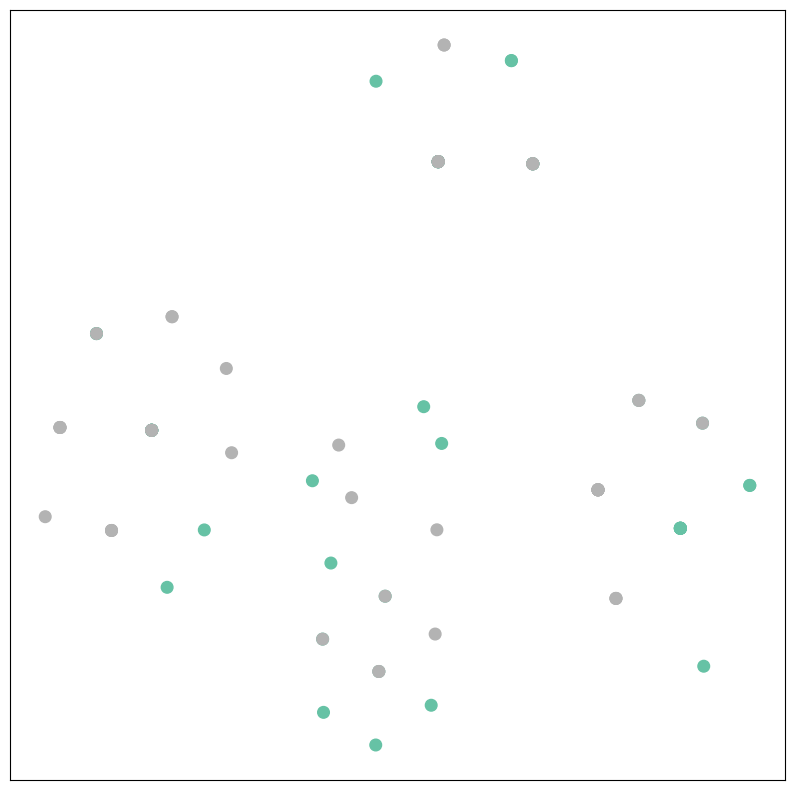

In [115]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse

# Helper function for visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


# Step 4: Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Model parameters
input_dim = X.shape[1]  # Number of features (gene expressions)
hidden_dim = 64  # Number of hidden neurons
output_dim = 2   # Number of classes (Luminal A / Luminal B)

# Initialize model
model = GCN(hidden_dim)
print(model)
# Step 5: Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()    #fa internamente la SOFTMAX alla fine

# Step 6: Create training and test masks
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# Use the first 80% nodes for training, and the last 20% for testing (come fare lo splitting ma sui nodi invece che sul dataset)
train_mask[:int(0.8 * num_nodes)] = True
test_mask[int(0.8 * num_nodes):] = True

# Step 7: Define training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[train_mask], data.y[train_mask])  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    return loss

# Step 8: Define test function
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Get class with highest probability for softmax -> la classe/label (0 o 1)
    test_correct = pred[test_mask] == data.y[test_mask]  # Compare with ground truth
    test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Compute accuracy
    return test_acc

# Step 9: Training the GCN
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Step 10: Test the GCN
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

# Visualize the learned embeddings
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)


Confronto con MLP

MLPBase(
  (fc1): Linear(in_features=1022, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Loss: 454428.0938
Epoch: 002, Loss: 582538.1250
Epoch: 003, Loss: 662544.1250
Epoch: 004, Loss: 746722.8125
Epoch: 005, Loss: 945418.1875
Epoch: 006, Loss: 562944.9375
Epoch: 007, Loss: 1067583.2500
Epoch: 008, Loss: 577477.1875
Epoch: 009, Loss: 569568.8750
Epoch: 010, Loss: 440678.5000
Epoch: 011, Loss: 755187.8750
Epoch: 012, Loss: 333138.5000
Epoch: 013, Loss: 1085307.2500
Epoch: 014, Loss: 314124.8125
Epoch: 015, Loss: 384827.4062
Epoch: 016, Loss: 300404.4375
Epoch: 017, Loss: 1278865.6250
Epoch: 018, Loss: 569302.7500
Epoch: 019, Loss: 888295.6875
Epoch: 020, Loss: 531486.6250
Epoch: 021, Loss: 352908.5938
Epoch: 022, Loss: 888050.1875
Epoch: 023, Loss: 894410.3750
Epoch: 024, Loss: 592269.7500
Epoch: 025, Loss: 522687.3438
Epoch: 026, Loss: 288835.1562
Epoch: 027, Loss: 492577.9062
Epoch: 028, Loss: 216018.4062
Epoch: 029, Loss: 1486981

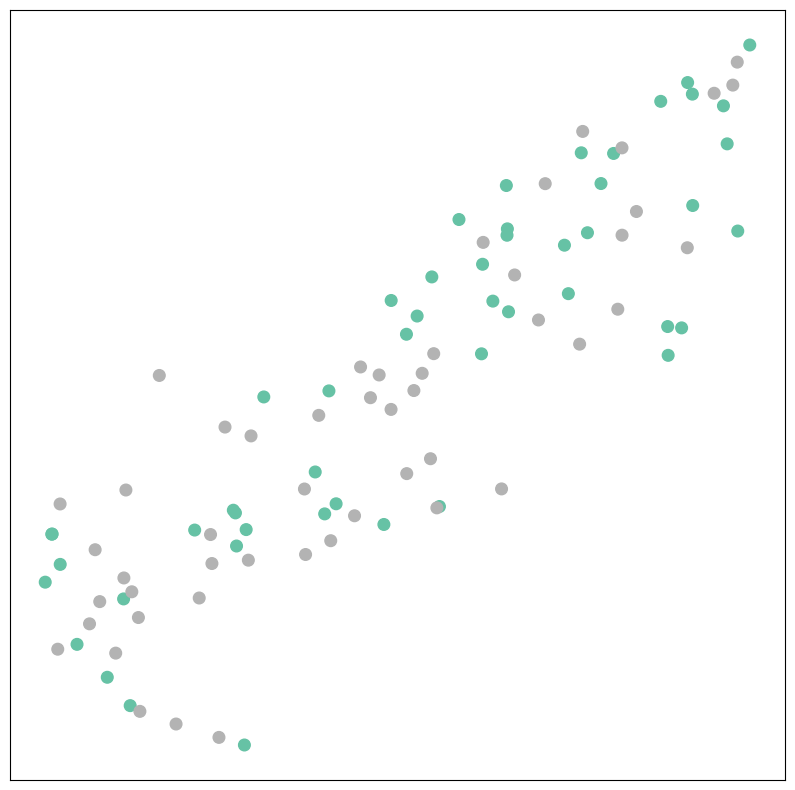

In [131]:
# Create training and test masks
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Use the first 80% nodes for training, and the last 20% for testing
train_mask[:int(0.8 * num_nodes)] = True
test_mask[int(0.8 * num_nodes):] = True

# Helper function for visualization
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Step 4: Define MLP model
class MLPBase(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPBase, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x

# Model parameters
input_dim = X.shape[1]  # Number of features (gene expressions)
hidden_dim = 64  # Number of hidden neurons
output_dim = 2   # Number of classes (Luminal A / Luminal B)

# Initialize model
mlp_model = MLPBase(input_dim, hidden_dim, output_dim)
print(mlp_model)

# Step 5: Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()  # Includes softmax internally

# Step 7: Define training loop
def train():
    mlp_model.train()
    optimizer.zero_grad()  # Clear gradients
    out = mlp_model(data.x)  # Forward pass (no edge_index for MLP)
    loss = criterion(out[train_mask], data.y[train_mask])  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    return loss

# Step 8: Define test function
def test():
    mlp_model.eval()
    out = mlp_model(data.x)  # Forward pass
    pred = out.argmax(dim=1)  # Get class with highest probability
    test_correct = pred[test_mask] == data.y[test_mask]  # Compare with ground truth
    test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Compute accuracy
    return test_acc

# Step 9: Training the MLP
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Step 10: Test the MLP
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

# Visualize the learned embeddings
mlp_model.eval()
out = mlp_model(data.x)
visualize(out, color=data.y)

In [124]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Define the MLP model
# 1. Definire il modello MLP
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)  # Adding another hidden layer
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout layer
        x = self.fc2(x)
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)  # Dropout layer
        x = self.fc3(x)
        return x

# Parameters
input_dim = X.shape[1]  # Number of features (gene expressions)
hidden_dim = 64          # Number of neurons in the hidden layer
output_dim = 2           # Number of classes (Luminal A / Luminal B)

# Initialize the model
model = MLP(input_dim, hidden_dim, output_dim)
print(model)

# Define loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define masks for training and testing
num_nodes = data.num_nodes  # Total number of nodes in the graph
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Use the first 80% nodes for training, and the last 20% for testing
train_mask[:int(0.8 * num_nodes)] = True
test_mask[int(0.8 * num_nodes):] = True

def train():
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x)  # Perform a forward pass
    # Compute the loss only for the training nodes
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters
    return loss

def test():
    model.eval()  # Set the model to evaluation mode
    out = model(data.x)  # Forward pass
    pred = out.argmax(dim=1)  # Get predicted classes
    # Check correct predictions against ground-truth labels
    test_correct = pred[test_mask] == data.y[test_mask]
    test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Calculate accuracy
    return test_acc

# Training Loop
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train()
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Evaluate the model
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


MLP(
  (fc1): Linear(in_features=1022, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 010, Loss: 0.5947
Epoch: 020, Loss: 0.3769
Epoch: 030, Loss: 0.2251
Epoch: 040, Loss: 0.0960
Epoch: 050, Loss: 0.0767
Epoch: 060, Loss: 0.0562
Epoch: 070, Loss: 0.1420
Epoch: 080, Loss: 0.1746
Epoch: 090, Loss: 0.0486
Epoch: 100, Loss: 0.0725
Test Accuracy: 0.6000
